In [ ]:
!pip install timm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

from torchvision import transforms

import timm
import itertools
import os

from tqdm import tqdm
from collections import Counter
from PIL import Image

import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_df = pd.read_csv('dataset/train/_classes.csv', encoding='latin-1')
val_df = pd.read_csv('dataset/valid/_classes.csv', encoding='latin-1')
test_df = pd.read_csv('dataset/test/_classes.csv', encoding='latin-1')

In [4]:
train_df.head()

,filename,Crack,Red-Dots,Toothmark
0,CC_1251_jpg.rf.4dc355605353bc19d1a22cf28de17e0...,0,1,1
1,CC_860_jpg.rf.4ee00327095d74181730926dc4b72fdf...,0,1,0
2,CC_113_jpg.rf.4f1da59e8de8a232fb121aa39b7f4452...,0,0,1
3,CC_608_jpg.rf.516f965226baeeffe275612849b139c3...,0,1,1
4,CC_1296_jpg.rf.4ee906ad39cc9e18db27c6dc4abc965...,0,0,1


In [5]:
classes = ["Crack", "Red-Dots", "Toothmark"]

In [6]:
train_labels = train_df[classes].values
val_labels = val_df[classes].values
test_labels = test_df[classes].values

In [7]:
transform = transforms.Compose([
    transforms.Resize(384),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, img_names, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        self.img_names = img_names

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
          image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [9]:
train_folder_path = 'dataset/train'
train_image_files = os.listdir(train_folder_path)
train_image_files = [file for file in train_image_files if file.endswith('.jpg')]

val_folder_path = 'dataset/valid'
val_image_files = os.listdir(val_folder_path)
val_image_files = [file for file in val_image_files if file.endswith('.jpg')]

test_folder_path = 'dataset/test'
test_image_files = os.listdir(test_folder_path)
test_image_files = [file for file in test_image_files if file.endswith('.jpg')]

In [10]:
print(len(train_image_files))
print(len(train_labels))

1288
1288


In [11]:
print(len(train_image_files) == len(train_labels))
print(len(val_image_files) == len(val_labels))
print(len(test_image_files) == len(test_labels))

True
True
True


In [12]:
train_dataset = CustomDataset(img_dir=train_folder_path, img_names=train_image_files, labels=train_labels, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16)

In [13]:
val_dataset = CustomDataset(img_dir=val_folder_path, img_names=val_image_files, labels=val_labels, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [14]:
test_dataset = CustomDataset(img_dir=test_folder_path, img_names=test_image_files, labels=test_labels, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [15]:
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

torch.Size([3, 384, 384]) torch.Size([3])


In [16]:
batch = next(iter(train_dataloader))
print(batch[0].shape, batch[1].shape)

torch.Size([16, 3, 384, 384]) torch.Size([16, 3])


# Model Training

In [17]:
num_classes = len(train_labels[0])

In [18]:
temp = timm.create_model('deit3_base_patch16_384.fb_in22k_ft_in1k', pretrained=True, num_classes=0, global_pool='')
temp

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [19]:
class MultiOutputModel(nn.Module):
    def __init__(self, n_crack_classes, n_reddot_classes, n_toothmark_classes):
        super(MultiOutputModel, self).__init__()
        self.base_model = timm.create_model(
            'deit3_base_patch16_384.fb_in22k_ft_in1k',
            pretrained=True,
            num_classes=0,
            global_pool=''
        )
        self.last_channel = 768  # Updated to match embedding size
        self.norm = nn.LayerNorm(self.last_channel)
        self.classifier_crack = nn.Linear(self.last_channel, n_crack_classes)
        self.classifier_reddot = nn.Linear(self.last_channel, n_reddot_classes)
        self.classifier_toothmark = nn.Linear(self.last_channel, n_toothmark_classes)

    def forward(self, x):
        features = self.base_model(x)  # Shape: (batch_size, seq_len, embed_dim)
        features = self.norm(features)
        cls_token = features[:, 0, :]  # Use the [CLS] token
        return {
            'crack': self.classifier_crack(cls_token),
            'red_dots': self.classifier_reddot(cls_token),
            'toothmark': self.classifier_toothmark(cls_token)
        }

    def get_loss(self, outputs, labels):
        # Ensure labels are the correct shape
        crack_labels = labels[:, 0].unsqueeze(1).float()
        red_dots_labels = labels[:, 1].unsqueeze(1).float()
        toothmark_labels = labels[:, 2].unsqueeze(1).float()

        crack_loss = nn.BCEWithLogitsLoss()(outputs['crack'], crack_labels)
        red_dots_loss = nn.BCEWithLogitsLoss()(outputs['red_dots'], red_dots_labels)
        toothmark_loss = nn.BCEWithLogitsLoss()(outputs['toothmark'], toothmark_labels)

        total_loss = crack_loss + red_dots_loss + toothmark_loss
        return total_loss, {
            'crack': crack_loss,
            'red_dots': red_dots_loss,
            'toothmark': toothmark_loss
        }

In [20]:
model = MultiOutputModel(n_crack_classes=1, n_reddot_classes=1, n_toothmark_classes=1)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
# for images, labels in train_dataloader:
#     images = images.to(device)
#     labels = labels.to(device)
#     outputs = model(images)
#     print(outputs)
#     print(labels)
#     break

In [25]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    # Training phase
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_dataloader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        # Extract labels for each task and ensure correct shape and type
        crack_labels = labels[:, 0].unsqueeze(1).float()
        red_dots_labels = labels[:, 1].unsqueeze(1).float()
        toothmark_labels = labels[:, 2].unsqueeze(1).float()

        # Compute loss for each output
        loss_crack = criterion(outputs['crack'], crack_labels)
        loss_reddot = criterion(outputs['red_dots'], red_dots_labels)
        loss_toothmark = criterion(outputs['toothmark'], toothmark_labels)

        # Combine losses
        loss = loss_crack + loss_reddot + loss_toothmark

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    print(f'Training Loss: {epoch_loss:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_dataloader, desc='Validation'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Extract labels for each task and ensure correct shape and type
            crack_labels = labels[:, 0].unsqueeze(1).float()
            red_dots_labels = labels[:, 1].unsqueeze(1).float()
            toothmark_labels = labels[:, 2].unsqueeze(1).float()

            # Compute loss for each output
            loss_crack = criterion(outputs['crack'], crack_labels)
            loss_reddot = criterion(outputs['red_dots'], red_dots_labels)
            loss_toothmark = criterion(outputs['toothmark'], toothmark_labels)

            # Combine losses
            loss = loss_crack + loss_reddot + loss_toothmark

            val_loss += loss.item()

    val_epoch_loss = val_loss / len(val_dataloader)
    print(f'Validation Loss: {val_epoch_loss:.4f}')

Epoch 1/10


Training: 100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


Training Loss: 2.0424


Validation: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


Validation Loss: 2.0483
Epoch 2/10


Training: 100%|██████████| 81/81 [00:44<00:00,  1.83it/s]


Training Loss: 2.0096


Validation: 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


Validation Loss: 1.9942
Epoch 3/10


Training: 100%|██████████| 81/81 [00:47<00:00,  1.69it/s]


Training Loss: 1.9994


Validation: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Validation Loss: 1.9962
Epoch 4/10


Training: 100%|██████████| 81/81 [00:42<00:00,  1.93it/s]


Training Loss: 2.0003


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]


Validation Loss: 2.0171
Epoch 5/10


Training: 100%|██████████| 81/81 [00:42<00:00,  1.93it/s]


Training Loss: 2.0159


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]


Validation Loss: 2.0360
Epoch 6/10


Training: 100%|██████████| 81/81 [00:42<00:00,  1.92it/s]


Training Loss: 2.0203


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]


Validation Loss: 2.0416
Epoch 7/10


Training: 100%|██████████| 81/81 [00:42<00:00,  1.92it/s]


Training Loss: 2.0097


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


Validation Loss: 2.0092
Epoch 8/10


Training: 100%|██████████| 81/81 [00:42<00:00,  1.91it/s]


Training Loss: 2.0005


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


Validation Loss: 1.9963
Epoch 9/10


Training: 100%|██████████| 81/81 [00:42<00:00,  1.91it/s]


Training Loss: 1.9981


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


Validation Loss: 1.9937
Epoch 10/10


Training: 100%|██████████| 81/81 [00:42<00:00,  1.92it/s]


Training Loss: 1.9978


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]

Validation Loss: 1.9907


# Thresholding

In [ ]:
train_predictions = []
sigmoid = nn.Sigmoid()

for image in tqdm(train_df['filename']):
    img_path = os.path.join(train_folder_path, image)
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img)
        # Apply sigmoid to each output separately
        pred_sigmoid = {key: sigmoid(value) for key, value in pred.items()}
    # Move tensors to CPU and convert to numpy arrays
    pred_numpy = {key: value.cpu().numpy() for key, value in pred_sigmoid.items()}
    train_predictions.append(pred_numpy)

# Now extract probabilities for each class
crack_probs = [output['crack'][0][0] for output in train_predictions]
red_dots_probs = [output['red_dots'][0][0] for output in train_predictions]
toothmark_probs = [output['toothmark'][0][0] for output in train_predictions]

100%|██████████| 1288/1288 [00:57<00:00, 22.36it/s]


In [ ]:
df_probs = pd.DataFrame({
    'Crack': crack_probs,
    'Red-Dots': red_dots_probs,
    'Toothmark': toothmark_probs
})

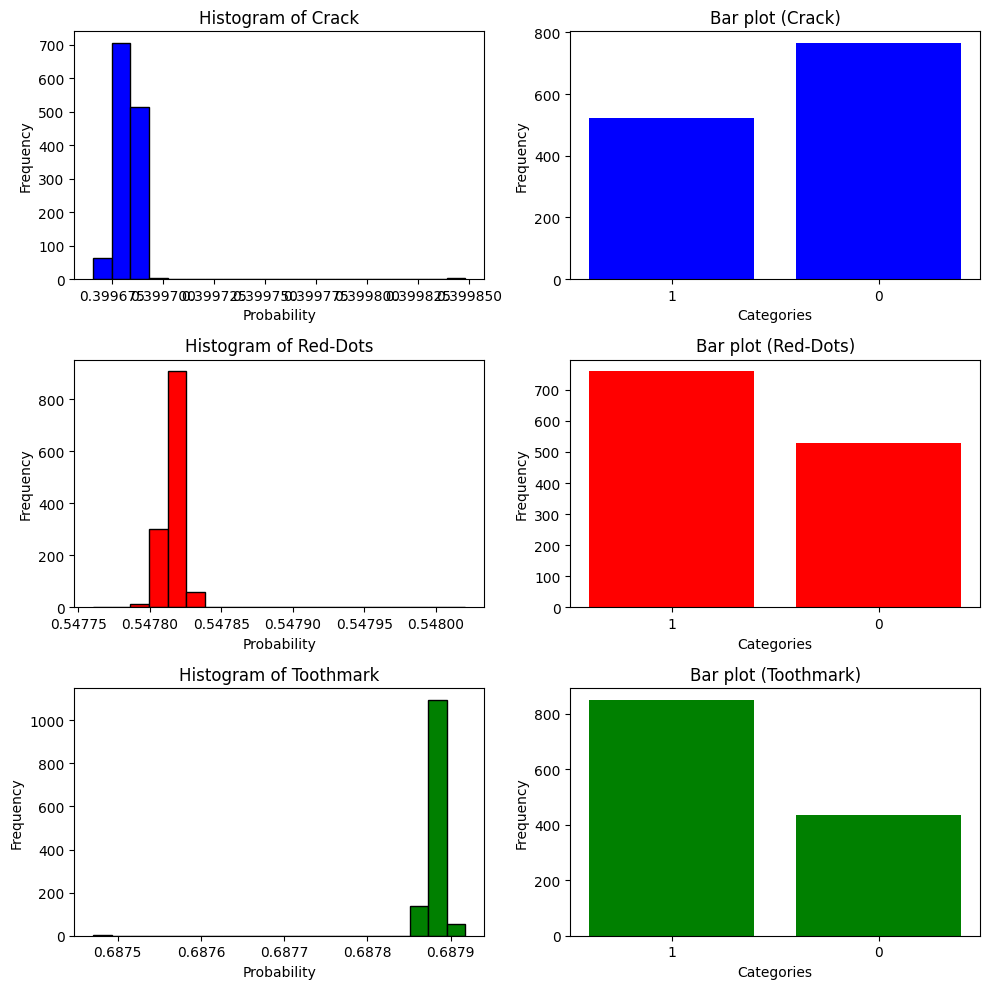

In [ ]:
colors = ["blue","red","green"]
feature_list = ["Crack","Red-Dots","Toothmark"]
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(len(feature_list)):
    axes[i,0].hist(df_probs.iloc[:, i], bins=20,edgecolor = "black",color = colors[i])
    axes[i,0].set_xlabel('Probability')
    axes[i,0].set_ylabel('Frequency')
    axes[i,0].set_title(f'Histogram of {feature_list[i]}')

    axes[i,1].bar(["1","0"], [np.sum(train_df.iloc[:, i+1]),len(train_df) - np.sum(train_df.iloc[:, i+1])], color = colors[i])
    axes[i,1].set_xlabel('Categories')
    axes[i,1].set_ylabel('Frequency')
    axes[i,1].set_title(f'Bar plot ({train_df.columns[i+1]})')

plt.tight_layout()

In [ ]:
def find_optimal_thresholds(probs, groundtruths, labels):
  optimal_thresholds = {}
  for i, label in enumerate(labels):
    label_probs = probs[:, i]
    label_groundtruth = groundtruths[:, i]

    best_threshold = 0.0
    best_f1 = -1.0

    for threshold in np.arange(0.01, 1.01, 0.001):
      binary_predictions = (label_probs >= threshold).astype(int)
      f1 = f1_score(label_groundtruth, binary_predictions)

      if f1 > best_f1:
        best_threshold = threshold
        best_f1 = f1

    optimal_thresholds[label] = {
        "threshold": round(best_threshold, 2),
        "f1_score": best_f1
    }

  return optimal_thresholds

In [ ]:
crack_prob = df_probs["Crack"].values
crack_groundtruth = np.array(train_df['Crack'])
red_dots_prob = df_probs["Red-Dots"].values
red_dots_groundtruth = np.array(train_df['Red-Dots'])
toothmark_prob = df_probs["Toothmark"].values
toothmark_groundtruth = np.array(train_df['Toothmark'])

probs = np.stack((crack_prob, red_dots_prob, toothmark_prob), axis=1)
groundtruths = np.stack((crack_groundtruth, red_dots_groundtruth, toothmark_groundtruth), axis=1)
labels = ["Crack", "Red-Dots", "Toothmark"]

optimal_thresholds = find_optimal_thresholds(probs, groundtruths, labels)

for label, values in optimal_thresholds.items():
  print(f"Label: {label}")
  print(f"Optimal Threshold: {values['threshold']}")
  print(f"F1 Score: {values['f1_score']}")
  print()

Label: Crack
Optimal Threshold: 0.01
F1 Score: 0.5775814467145224

Label: Red-Dots
Optimal Threshold: 0.01
F1 Score: 0.7415730337078652

Label: Toothmark
Optimal Threshold: 0.01
F1 Score: 0.7956989247311828



In [ ]:
optimal_thresholds

{'Crack': {'threshold': 0.01, 'f1_score': 0.5775814467145224},
 'Red-Dots': {'threshold': 0.01, 'f1_score': 0.7415730337078652},
 'Toothmark': {'threshold': 0.01, 'f1_score': 0.7956989247311828}}

In [ ]:
thresholds = {'crack': optimal_thresholds['Crack']['threshold'],
              'red_dots': optimal_thresholds['Red-Dots']['threshold'],
              'toothmark': optimal_thresholds['Toothmark']['threshold']}

# Evaluation on Validation/Testing Set

In [ ]:
def evaluate_model(model, dataloader, criterion, device, thresholds, class_names):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # outputs is a dictionary

            # Compute loss for each output separately
            crack_labels = labels[:, 0].unsqueeze(1).float()
            red_dots_labels = labels[:, 1].unsqueeze(1).float()
            toothmark_labels = labels[:, 2].unsqueeze(1).float()

            loss_crack = criterion(outputs['crack'], crack_labels)
            loss_reddot = criterion(outputs['red_dots'], red_dots_labels)
            loss_toothmark = criterion(outputs['toothmark'], toothmark_labels)

            loss = loss_crack + loss_reddot + loss_toothmark

            # Accumulate running loss
            running_loss += loss.item() * images.size(0)

            # Apply sigmoid to each output and collect predictions
            sigmoid_outputs = {}
            preds = {}
            for key in outputs.keys():
                sigmoid_output = torch.sigmoid(outputs[key]).cpu().numpy()  # Shape: (batch_size, 1)
                threshold = thresholds[key]
                pred = (sigmoid_output > threshold).astype(int)  # Binary predictions
                sigmoid_outputs[key] = sigmoid_output
                preds[key] = pred

            # Stack predictions and labels
            batch_preds = np.concatenate([preds['crack'], preds['red_dots'], preds['toothmark']], axis=1)  # Shape: (batch_size, 3)
            batch_labels = labels.cpu().numpy()  # Shape: (batch_size, 3)

            all_predictions.append(batch_preds)
            all_labels.append(batch_labels)

    # Compute average loss
    avg_loss = running_loss / len(dataloader.dataset)

    # Convert lists to arrays
    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    report = classification_report(all_labels, all_predictions, target_names=class_names)

    # Plot confusion matrices for each class
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(all_labels[:, i], all_predictions[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {class_name}', class_name])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - {class_name}')
        plt.show()

    return all_predictions, all_labels, avg_loss, precision, recall, f1, report

## Validation Set

Evaluating: 100%|██████████| 13/13 [00:09<00:00,  1.41batch/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


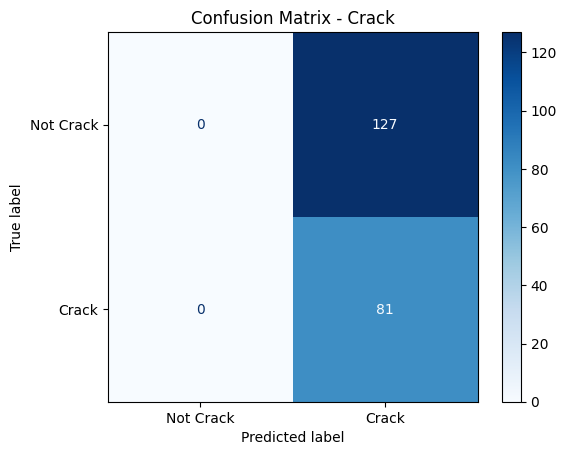

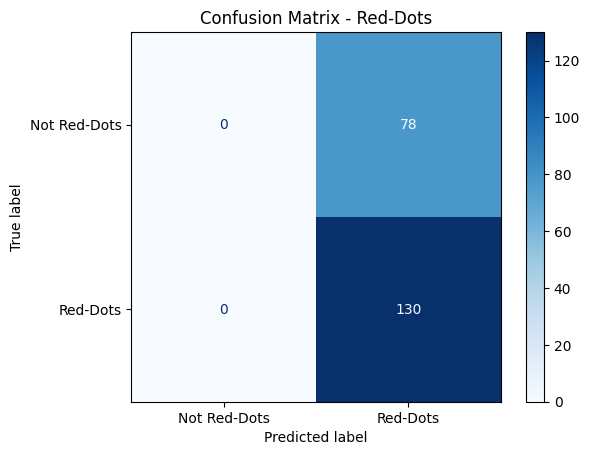

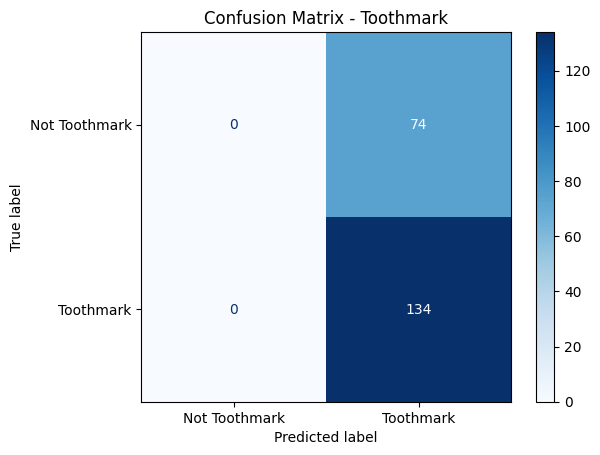

In [ ]:
all_predictions, all_labels, avg_val_loss, val_precision, val_recall, val_f1, val_report = evaluate_model(
    model=model,
    dataloader=val_dataloader,
    criterion=nn.BCEWithLogitsLoss(),
    device=device,
    thresholds=thresholds,
    class_names=classes
)

In [ ]:
print(f'Validation Loss: {avg_val_loss:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1-score: {val_f1:.4f}')
print(f'Classification Report:\n{val_report}')

Validation Loss: 1.9977
Validation Precision: 0.5529
Validation Recall: 1.0000
Validation F1-score: 0.7045
Classification Report:
              precision    recall  f1-score   support

       Crack       0.39      1.00      0.56        81
    Red-Dots       0.62      1.00      0.77       130
   Toothmark       0.64      1.00      0.78       134

   micro avg       0.55      1.00      0.71       345
   macro avg       0.55      1.00      0.70       345
weighted avg       0.58      1.00      0.73       345
 samples avg       0.55      0.94      0.67       345



## Testing Set

Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.53batch/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


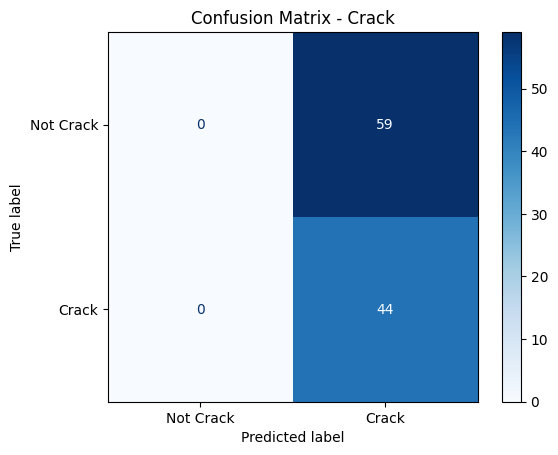

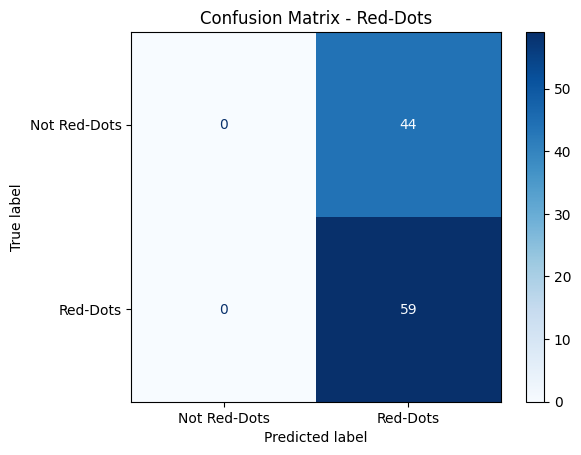

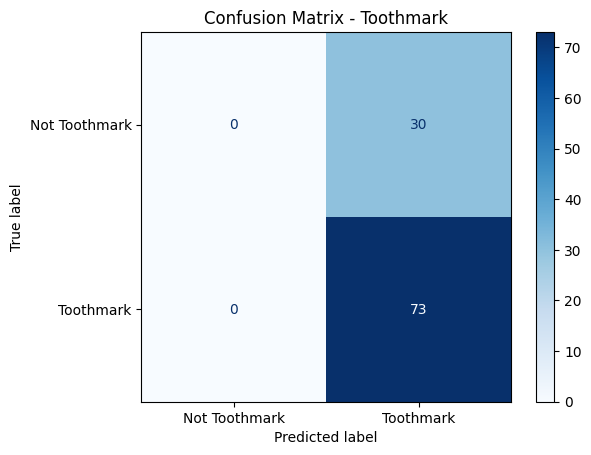

In [ ]:
test_predictions, test_labels, avg_test_loss, test_precision, test_recall, test_f1, test_report = evaluate_model(
    model=model,
    dataloader=test_dataloader,
    criterion=nn.BCEWithLogitsLoss(),
    device=device,
    thresholds=thresholds,
    class_names=classes
)

In [ ]:
print(f'Test Loss: {avg_test_loss:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-score: {test_f1:.4f}')
print(f'Classification Report:\n{test_report}')

Test Loss: 1.9721
Test Precision: 0.5696
Test Recall: 1.0000
Test F1-score: 0.7189
Classification Report:
              precision    recall  f1-score   support

       Crack       0.43      1.00      0.60        44
    Red-Dots       0.57      1.00      0.73        59
   Toothmark       0.71      1.00      0.83        73

   micro avg       0.57      1.00      0.73       176
   macro avg       0.57      1.00      0.72       176
weighted avg       0.59      1.00      0.74       176
 samples avg       0.57      0.91      0.68       176

